# Neural Ordinary Differential Equations

# Implementation 

In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

Some simple implementations for ordinary differential equation initial value solver (Euler's ODE and Runge Kutta 4th Order)

In [100]:
class euler_solver():
    def __init__(self, h_max=0.25): 
        self.h_max = h_max

    def solve(self, z0, t0, t1, f):
        n_steps = math.ceil((abs(t1 - t0) / self.h_max).max().item())

        h = (t1 - t0)/n_steps
        t = t0
        z = z0

        for i_step in range(n_steps):
            z = z + h * f(z, t)
            t = t + h
        return z

In [85]:
class rk4_solver():
    def __init__(self, h_max=0.25): 
        self.h_max = h_max

    def solve(self, z0, t0, t1, f):
        n = math.ceil((abs(t1 - t0) / self.h_max).max().item())

        h = (t1 - t0)/n
        z = z0
        t = t0

        for i in range(n):
            "Apply Runge Kutta Formulas to find next value of y"
            k1 = f(z, t)
            k2 = f(z + 0.5 * k1, t + 0.5 * h)
            k3 = f(z + 0.5 * k2, t + 0.5 * h)
            k4 = f(z + k3, t + h)
    
            # Update next value of y
            z = z + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    
            # Update next value of x
            t = t + h
        return z

In [4]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

The code below incapsulates forward and backward passes of *Neural ODE*. We have to separate it from main ***torch.nn.Module*** because custom backward function can't be implemented inside Module, but can be implemented inside ***torch.autograd.Function***. So this is just a little workaround.

This function underlies the main Neural ODE algorithm from the original Paper.

In [5]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func, ode_solver):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solver.solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.ode_solver = ode_solver
        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        ode_solver = ctx.ode_solver
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solver.solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None, None

Wrap ODE Adjoint function in **nn.Module** for convenience.

In [82]:
class NeuralODE(nn.Module):
    def __init__(self, func, ode_solver):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func
        self.ode_solver = ode_solver

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func, self.ode_solver)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Tests

## Learning true dynamics function

First, we'll test a simple linear ODE to show if it can indeed restore true dynamics function using sampled data. 

Dynamics is given with a matrix:

$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$

Trained function here is also a simple matrix.

In [7]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

Dynamics is simply given with a matrix.

In [8]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

Initial random linear dynamics function to be optimized

In [9]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

Methods for performing experiments and plotting the results

In [15]:
def to_np(x):
    return x.detach().cpu().numpy()

In [16]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [17]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"imgs/{name}/{i}.png")
            clear_output(wait=True)

In [18]:
ode_true = NeuralODE(SpiralFunctionExample(), euler_solver())
ode_trained = NeuralODE(RandomLinearODEF(), euler_solver())

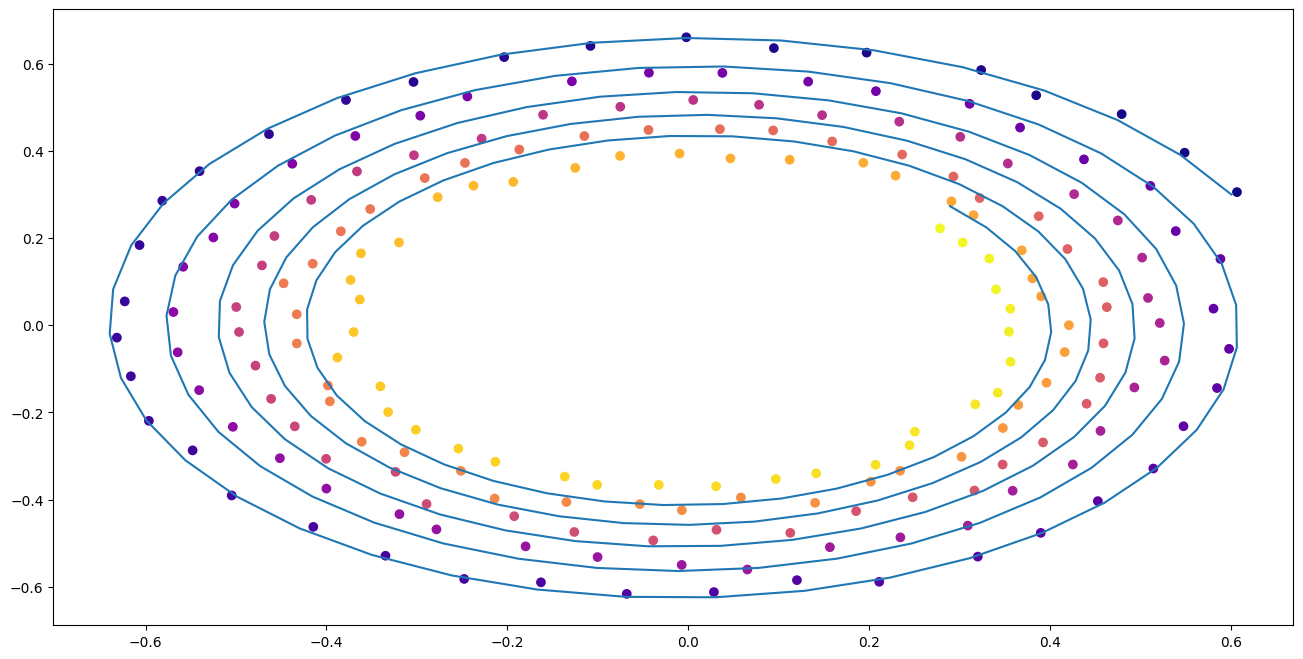

In [19]:
conduct_experiment(ode_true, ode_trained, 3000, "linear", plot_freq=300)

In [20]:
ode_true = NeuralODE(SpiralFunctionExample(), rk4_solver())
ode_trained = NeuralODE(RandomLinearODEF(), rk4_solver())

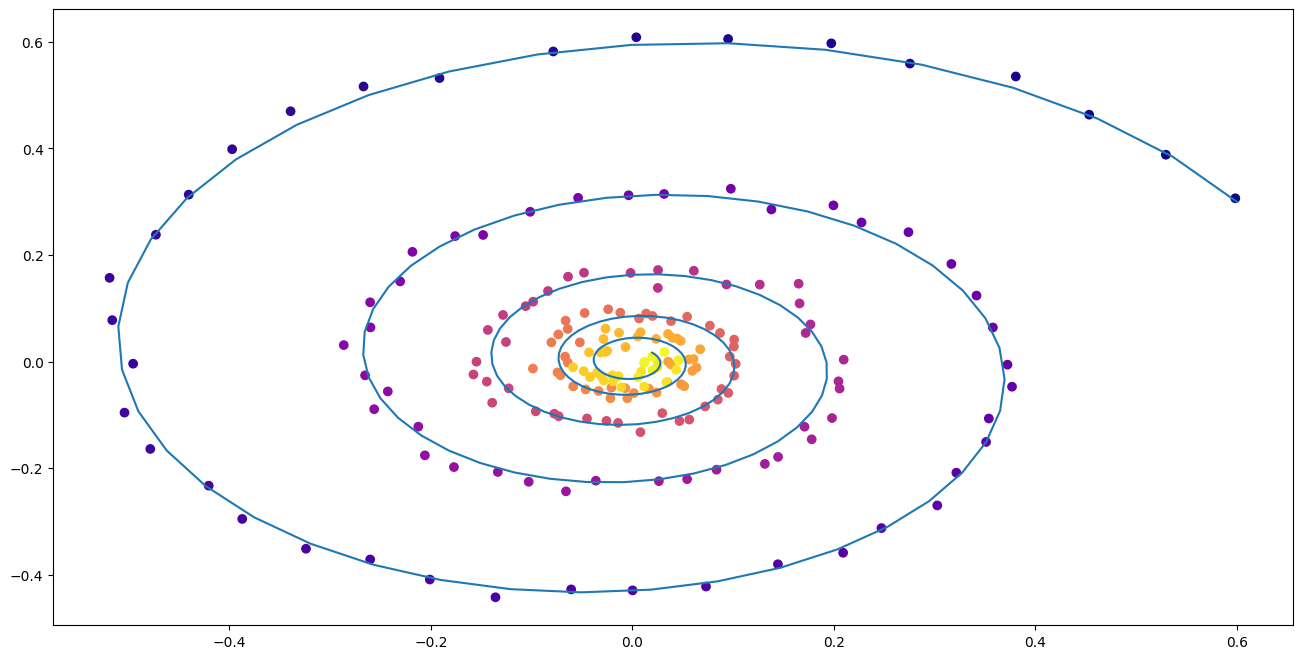

In [21]:
conduct_experiment(ode_true, ode_trained, 1800, "linear_rk4", plot_freq=300)

More sophisticated dynamics for creating trajectories

In [22]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

Dynamics function to be optimized is MLP

In [23]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [24]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func, euler_solver())

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func, euler_solver())

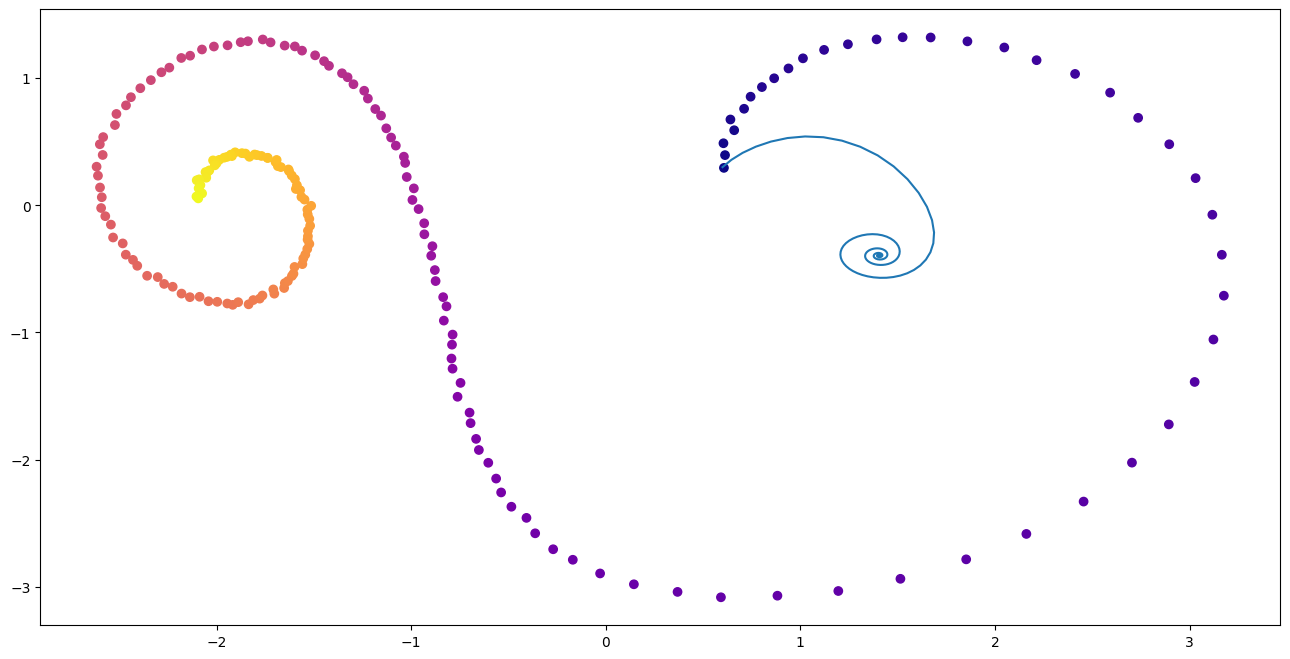

In [25]:
conduct_experiment(ode_true, ode_trained, 10000, "comp", plot_freq=1000)

In [26]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func, rk4_solver())

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func, rk4_solver())

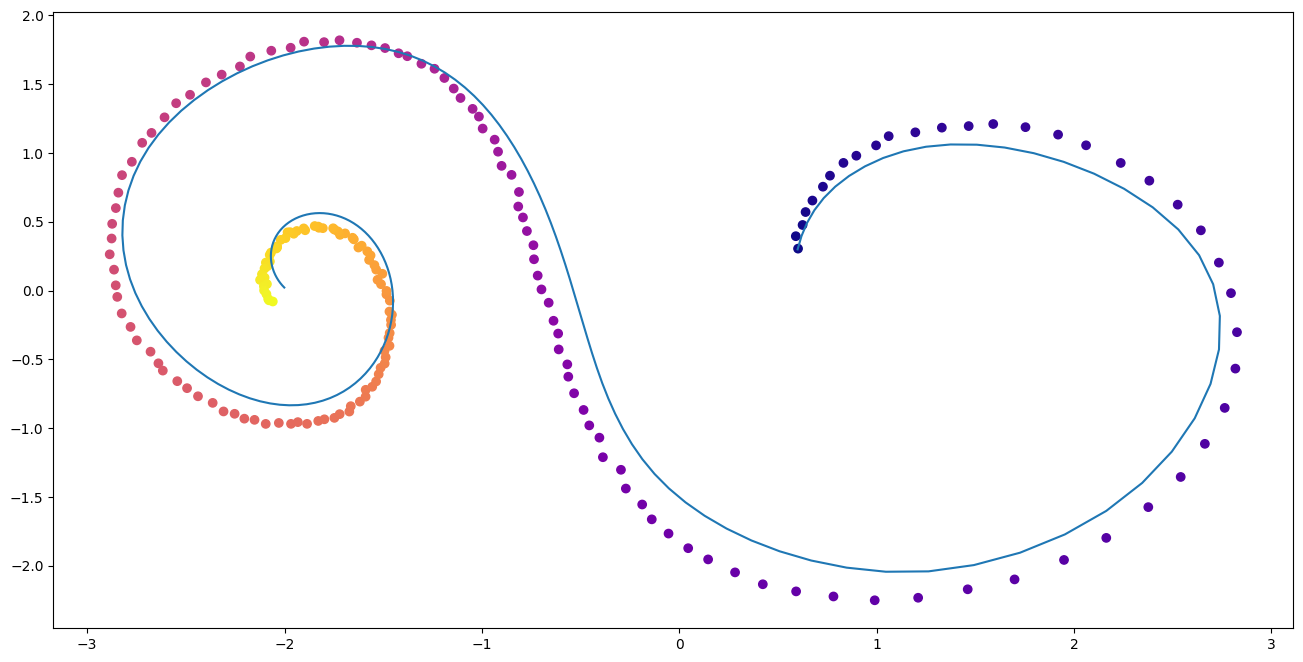

In [27]:
conduct_experiment(ode_true, ode_trained, 10000, "comp_rk4", plot_freq=1000)

As one can see, Neural ODEs are pretty successful in approximating dynamics. Now let's check perfomance on MNIST.

### Testing Neural ODE architecture on MNIST


In [28]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [29]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [30]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [31]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

In [32]:
def train(epoch, model, optimizer):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [33]:
def test(model, optimizer):
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [34]:
func = ConvODEF(64)
ode = NeuralODE(func, euler_solver(0.05))
model_es = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model_es = model_es.cuda()

optimizer = torch.optim.Adam(model_es.parameters())

In [35]:
n_epochs = 5
train_losses = []

for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch, model_es, optimizer)
    test(model_es, optimizer)

Training Epoch 1...


C:\Users\rinok\AppData\Local\Temp\ipykernel_22404\3314054178.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.17129
Testing...


C:\Users\rinok\AppData\Local\Temp\ipykernel_22404\1439841724.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.000%
Training Epoch 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.05644
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.980%
Training Epoch 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03887
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.840%
Training Epoch 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03375
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.030%
Training Epoch 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02531
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.130%


In [36]:
func = ConvODEF(64)
ode = NeuralODE(func, rk4_solver(0.05))
model_rk4 = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model_rk4 = model_rk4.cuda()

optimizer = torch.optim.Adam(model_rk4.parameters())

In [37]:
n_epochs = 5
train_losses = []

for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch, model_rk4, optimizer)
    test(model_rk4, optimizer)

Training Epoch 1...


C:\Users\rinok\AppData\Local\Temp\ipykernel_22404\3314054178.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.15634
Testing...


C:\Users\rinok\AppData\Local\Temp\ipykernel_22404\1439841724.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.760%
Training Epoch 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.04945
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.840%
Training Epoch 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03699
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.890%
Training Epoch 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02968
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.990%
Training Epoch 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02609
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.120%


<Axes: title={'center': 'train error'}, xlabel='cum_data'>

<Figure size 900x500 with 0 Axes>

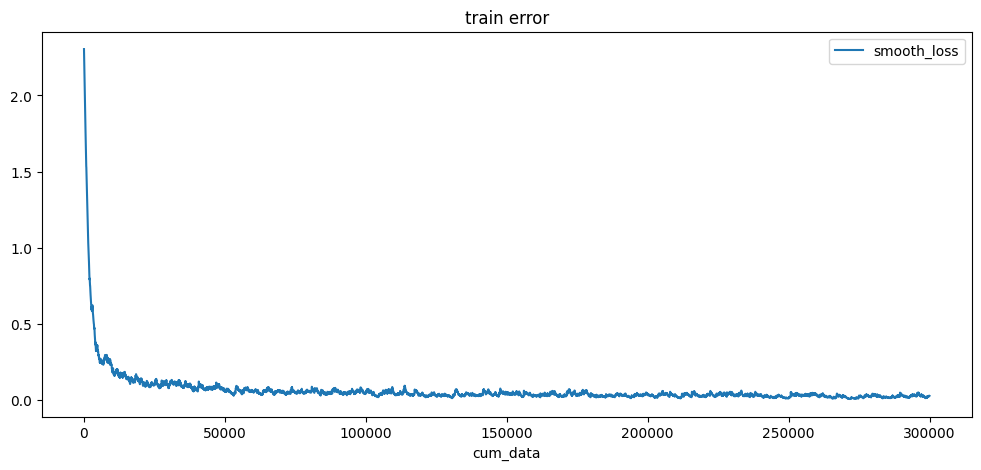

In [ ]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

## Text classification (AG News Dataset)

In [67]:
import time
import csv

In [68]:
KERNEL_SIZE = 3
STRIDE = 1
PADDING = 1

In [98]:
def norm(dim, type='group_norm'):
    return nn.BatchNorm1d(dim)
    
def conv1d(in_feats, out_feats, stride=1):
    return nn.Conv1d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)


def get_param_numbers(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def add_time(in_tensor, t):
    bs, d, s = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs,  1,s)), dim=1)


class ConvBlockOde(ODEF):
    def __init__(self, dim):
        super(ConvBlockOde, self).__init__()
        # 1 additional dim for time
        self.conv1 = conv1d(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv1d(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))

        return dxdt


class ConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock1D, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, KERNEL_SIZE, STRIDE, PADDING),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, KERNEL_SIZE, STRIDE, PADDING),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        residual = x
        return self.conv_block(x) + residual


class ContinuousResNet(nn.Module):
    def __init__(self, feature, vocab_size, embd_size=16, num_labels=4):
        super(ContinuousResNet, self).__init__()
        self.k = 4
        self.embed = nn.Embedding(vocab_size, embd_size)
        self.conv = nn.Conv1d(embd_size, 64, KERNEL_SIZE, STRIDE, PADDING)
        self.feature = feature
        self.norm = norm(64)
        hidden = 256
        self.fc = nn.Sequential(
            nn.Linear(64 * self.k, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_labels)
        )

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(0,2,1)
        x = self.conv(x)
        x = self.feature(x)
        x = self.norm(x)
        x = F.relu(x)
        h = x.topk(self.k)[0].view(-1, 64 * self.k)
        x = self.fc(h)
        return x


In [118]:
class DataHelper():
    def __init__(self, sequence_max_length=1024):
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’"/|_#$%ˆ&*˜‘+=<>()[]{} '
        self.char_dict = {}
        self.UNK = 68
        self.sequence_max_length = sequence_max_length
        for i,c in enumerate(self.alphabet):
            self.char_dict[c] = i+1

    def char2vec(self, text):
        data = np.zeros(self.sequence_max_length)
        for i in range(0, len(text)):
            if i >= self.sequence_max_length:
                return data
            elif text[i] in self.char_dict:
                data[i] = self.char_dict[text[i]]
            else:
                data[i] = self.UNK
        return np.array(data)

    def load_csv_file(self, filename, num_classes, train=True, one_hot=False):
        if train:
            s1 = 120000
        else:
            s1 = 7600
        all_data =np.zeros(shape=(s1, self.sequence_max_length), dtype=int)
        labels =np.zeros(shape=(s1, 1), dtype=int)

        # labels = []
        with open(filename) as f:
            reader = csv.DictReader(f, fieldnames=['class'], restkey='fields')
            # reader = np.genfromtxt(f)
            for i,row in enumerate(reader):
                if one_hot:
                    one_hot = np.zeros(num_classes)
                    one_hot[int(row['class']) - 1] = 1
                    labels[i] = one_hot
                else:
                    labels[i] = int(row['class']) - 1
                text = row['fields'][-1].lower()
                all_data[i] = self.char2vec(text)
        f.close()
        return all_data, labels

    def load_dataset(self, dataset_path):
        with open(dataset_path+"classes.txt") as f:
            classes = []
            for line in f:
                classes.append(line.strip())
        f.close()
        num_classes = len(classes)
        train_data, train_label = self.load_csv_file(dataset_path + 'train.csv', num_classes)
        test_data, test_label = self.load_csv_file(dataset_path + 'test.csv', num_classes, train=False)
        print(train_data.shape, test_data.shape)
        return train_data, train_label, test_data, test_label

    def batch_iter(self, data, batch_size, num_epochs, shuffle=True):
        data_size = len(data)
        num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
        # for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            batch = shuffled_data[start_index:end_index]
            # batch_data, label = batch[:,  self.sequence_max_length-1], batch[:, -1]
            batch_data, label = np.split(batch, [self.sequence_max_length],axis=1)
            yield np.array(batch_data, dtype=int), label


In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

func = ConvBlockOde(64)
feat = NeuralODE(func, euler_solver(0.05))

sequence_max_length = 1014
batch_size = 256
max_epochs = 50
database_path = './data/ag_news/'
data_helper = DataHelper(sequence_max_length=sequence_max_length)
vocab = len(data_helper.char_dict.keys()) + 2
model = ContinuousResNet(feat, vocab_size=vocab).to(device)
criterion = nn.CrossEntropyLoss().to(device)
train_loss_all = []

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
epoch_time_all = []
train_loss_all = []
accuracy_all = []
print('Trained model has {} parameters'.format(get_param_numbers(model)))

for epoch in range(max_epochs):
    train_losses = []

    t_start = time.time()

    train_data, train_label, test_data, test_label = data_helper.load_dataset(database_path)
    train_batches = data_helper.batch_iter(np.column_stack((train_data, train_label)), batch_size, max_epochs)

    train_size = train_data.shape[0] // batch_size
    test_size = test_data.shape[0] // batch_size
    for j, batch in tqdm(enumerate(train_batches), total=train_size):
        train_data_b,label = batch
        train_data_b = torch.from_numpy(train_data_b).to(device)
        label = torch.from_numpy(label).squeeze().type(torch.LongTensor).to(device)
        model.zero_grad()

        output = model(train_data_b)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]

    epoch_time_all.append(time.time() - t_start)
    train_loss_all.append(train_losses)
    print('Train loss: {:.4f}'.format(np.mean(train_losses)))

    test_loader = data_helper.batch_iter(np.column_stack((test_data, test_label)), batch_size, max_epochs)

    model.eval()
    print("Testing...")
    num_items = 0
    accuracy = 0
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=test_size):
            data = torch.from_numpy(data).to(device)
            target = torch.from_numpy(target).squeeze().to(device)
            output = model(data)
            accuracy += torch.sum((torch.argmax(output, dim=1) == target).long()).item()
    accuracy = accuracy * 100 / test_data.shape[0]
    print("Accuracy: {}%".format(np.round(accuracy, 3)))
    accuracy_all.append(np.round(accuracy, 3))
    model.train()
    torch.save({'state_dict': model.state_dict()}, 'models/model_' + str(epoch) + '.pth')

    torch.save({'accuracy': accuracy_all,
                'train_loss': train_loss_all,
                'epoch_time': epoch_time_all}, 'info/log.pkl')

Trained model has 162196 parameters
(120000, 1014) (7600, 1014)


C:\Users\rinok\AppData\Local\Temp\ipykernel_22404\2022584432.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, batch in tqdm(enumerate(train_batches), total=train_size):


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.4851
Testing...


C:\Users\rinok\AppData\Local\Temp\ipykernel_22404\2022584432.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=test_size):


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 61.908%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.3152
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 67.724%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.2579
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 71.632%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.2310
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 73.355%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.2155
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 80.408%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.2027
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 80.934%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.1961
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 81.447%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.1869
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 77.974%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.1791
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 81.934%
(120000, 1014) (7600, 1014)


  0%|          | 0/468 [00:00<?, ?it/s]

Train loss: 0.1727
Testing...


  0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 82.263%


<Axes: title={'center': 'train loss'}, xlabel='epoch'>

<Figure size 900x500 with 0 Axes>

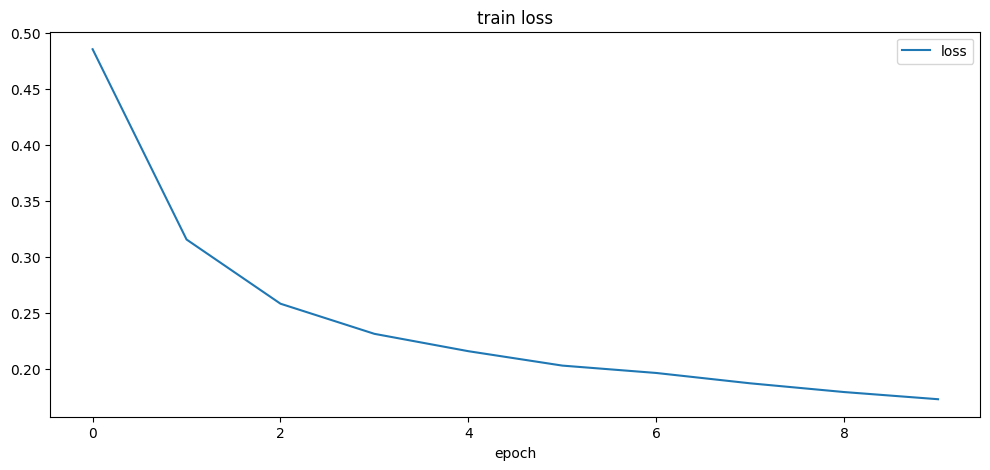

In [117]:
import pandas as pd

plt.figure(figsize=(9, 5))
mean_loss = [np.mean(train_losses) for train_losses in train_loss_all]
history = pd.DataFrame({"loss": mean_loss})
history["epoch"] = history.index
history.plot(x="epoch", y="loss", figsize=(12, 5), title="train loss")

<Axes: title={'center': 'test accuracy'}, xlabel='epoch'>

<Figure size 900x500 with 0 Axes>

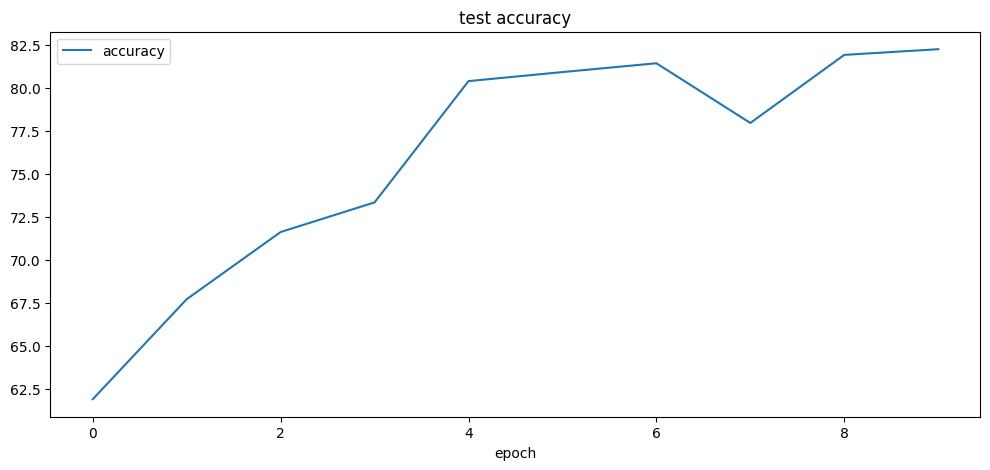

In [116]:
plt.figure(figsize=(9, 5))
mean_loss = [np.mean(train_losses) for train_losses in train_loss_all]
history = pd.DataFrame({"accuracy": accuracy_all})
history["epoch"] = history.index
history.plot(x="epoch", y="accuracy", figsize=(12, 5), title="test accuracy")